# TTC Headway Analysis (WIP 3)
Mohamed Osman - 9 Dec 2019

The 'headway' is the length of time between the arrival times of two consecutive trains at a given station. Using historical TTC arrival data (Bloor-Danforth, September 2019), we can do some preliminary analyses involving that metric.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.dates as mdates

pd.set_option('display.max_rows', 1000)
plt.rcParams["figure.figsize"] = (25,12)

## Read in data

In [2]:
polls = pd.read_csv('polls.csv');
requests = pd.read_csv('requests.csv');
responses = pd.read_csv('responses.csv');

## Create initial dataset
The datasets *requests.csv* and *responses.csv* will be used for this analysis.

*requests.csv* is a dataset consisting of logs relating to the scraper interacting with TTC's API. Each request is a batch of arrival times for a station, or the next n trains to arrive at a station, with each batch being uniquely identified by a *request_id*. *request_date* is the timestamp for a request, assumed to be the exact time where the request data was retrieved by the API.

*responses.csv* includes all of the requests obtained by the scraper. Each row documents one arrival time for a train towards a station, including an assortment of qualitative and quantatative data for each one. Each row is associated with a *request_id*.

The first thing we want to do is merge *request_date* with *responses.csv* on *request_id* so we have a timestamp associated with each row.

In [3]:
# order of stations, west to east
station_order = ["KIP","ISL","RYK","OML","JNE","RUN","HPK","KEL","DNW","LAN","DUF","OSS","CHR","BAT","BSP","SGL","BAU","YNG","SHE","CFK","BRD","CHE","PAP","DON","GWD","COX","MST","VPK","WAR","KEN","NaN"]

# merge responses with request dates
ttc = pd.merge(responses,requests[['requestid','request_date']],on='requestid')

# remove numbers at end of station
ttc['station_char'] = ttc['station_char'].str[0:3]

# only want to look at Bloor-Danforth lines for now
ttc_init = ttc.loc[ttc['subwayline'] == 'BD']

# sort by trains left to right
ttc_init = ttc_init[ttc_init['station_char'].isin(station_order)]
ttc_init['station_char']=pd.Categorical(ttc_init['station_char'], station_order)

# sort data by estimated time, station, and request date (ascending)
ttc_init = ttc_init.sort_values(by=['station_char','request_date','timint'])

In [4]:
ttc_init

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,request_date
245791,44049,32906364177,KIP,BD,Normal,0.000000,East,214,AtStation,Westbound<br/> To Kipling,2019-09-01 05:41:40.642173-04:00
277117,49653,32906364181,KIP,BD,Normal,0.000000,East,214,AtStation,Westbound<br/> To Kipling,2019-09-01 05:42:40.473713-04:00
218793,39151,32906364183,KIP,BD,Normal,0.000000,East,214,AtStation,Westbound<br/> To Kipling,2019-09-01 05:43:40.443185-04:00
342455,61272,32906364185,KIP,BD,Normal,0.000000,East,214,Delayed,Westbound<br/> To Kipling,2019-09-01 05:44:40.322398-04:00
106772,19055,32906364187,KIP,BD,Normal,0.000000,East,214,Delayed,Westbound<br/> To Kipling,2019-09-01 05:45:40.743561-04:00
...,...,...,...,...,...,...,...,...,...,...,...
8062156,1412108,33039742239,KEN,BD,Normal,0.290576,East,237,Delayed,Westbound<br/> To Kipling,2019-10-01 02:59:40.586077-04:00
8062160,1412108,33039742167,KEN,BD,Normal,0.290576,East,237,Delayed,Westbound<br/> To Kipling,2019-10-01 02:59:40.586077-04:00
8062157,1412108,33039742240,KEN,BD,Normal,0.296222,West,232,Delayed,Westbound<br/> To Kipling,2019-10-01 02:59:40.586077-04:00
8062161,1412108,33039742168,KEN,BD,Normal,0.296222,West,232,Delayed,Westbound<br/> To Kipling,2019-10-01 02:59:40.586077-04:00


## Transform dataset

Before calculating headway, we want to transform our dataset and remove unnecessary data so that it will only have a single arrival time for a unique train reaching a station. This will be done in a few steps.

Each row in our dataset can be seen as a *recording* of a train's position at a certain moment. It includes variables such as *request_date*, *station_char*, the name of the station the train is approaching, and *timint*, the estimated time until it reaches a station. An *arrival time* in particular is the last recording of a train that is about to arrive, or just arrived at a station.

To find arrival times, we will need to do the following:



### Remove unneeded request data

Each request is comprised of up to six recordings, detailing the next three trains to arrive from both directions. We only care about the trains closest to the station, so we'll remove the rest.

In [5]:
ttc_1 = ttc_init.copy().sort_values(by=['requestid','traindirection','timint']).drop_duplicates(subset=['requestid', 'traindirection'])

In [6]:
ttc_1

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,request_date
51,9,32909720627,BSP,BD,Normal,2.896029,East,213,Arriving,Eastbound</br> To Kennedy,2019-09-01 15:29:40.820265-04:00
57,9,32909720721,BSP,BD,Normal,3.375428,West,201,Arriving,Westbound<br/> To Kipling,2019-09-01 15:29:40.820265-04:00
63,10,32909720630,SGL,BD,Normal,0.000000,East,212,AtStation,Eastbound</br> To Kennedy,2019-09-01 15:29:40.820617-04:00
69,10,32909720718,SGL,BD,Normal,2.569665,West,201,Arriving,Westbound<br/> To Kipling,2019-09-01 15:29:40.820617-04:00
141,22,32909720636,YNG,BD,Normal,1.891933,East,212,Arriving,Eastbound</br> To Kennedy,2019-09-01 15:29:40.825010-04:00
...,...,...,...,...,...,...,...,...,...,...,...
11954782,2086677,32996716783,VPK,BD,Normal,3.588844,West,234,Arriving,Eastbound<br/> To Kennedy,2019-09-17 07:03:40.514750-04:00
11954785,2086678,32996716772,WAR,BD,Normal,0.265235,East,39,Arriving,Westbound<br/> To Kipling,2019-09-17 07:03:40.515113-04:00
11954788,2086678,32996716781,WAR,BD,Normal,0.578534,West,235,Arriving,Eastbound<br/> To Kennedy,2019-09-17 07:03:40.515113-04:00
11954790,2086679,32996716775,KEN,BD,Normal,1.254785,East,240,Arriving,Westbound<br/> To Kipling,2019-09-17 07:03:40.515487-04:00


### Remove repeated zero-time recordings

When a train is delayed, the dataset will show multiple recordings of the train stuck at that point, all with the same *timint*. The delay data will help us out later, but the repeated recordings with *timint* being 0 is largely useless data since only the first recording can be an arrival time. So, they will need to be removed.

In [7]:
#sort such that delays are bunched together by trainid
ttc_2a = ttc_1.copy().sort_values(by=['trainid','station_char','request_date'])

# remove all rows that have the exact same 0 timint, given they're at the same station
s_tim = (ttc_2a['timint']) == (ttc_2a['timint'].shift(1,fill_value = -1))
s_stc = (ttc_2a['station_char']) == (ttc_2a['station_char'].shift(1,fill_value = "NaN"))

ttc_2 = ttc_2a.copy().loc[~((s_tim) & (s_stc) & (ttc_2a['timint'] == 0))]

In [8]:
ttc_2

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,request_date
9801041,1711696,33005929792,KIP,BD,Normal,0.000000,West,1,AtStation,Westbound<br/> To Kipling,2019-09-19 16:46:56.311581-04:00
6352138,1118000,32994018601,ISL,BD,Normal,8.660772,West,1,Arriving,Eastbound<br/> To Kennedy,2019-09-16 19:04:40.660860-04:00
6228660,1096854,32994023433,ISL,BD,Normal,7.443395,West,1,Arriving,Eastbound<br/> To Kennedy,2019-09-16 19:05:47.983564-04:00
6092743,1073654,32994026490,ISL,BD,Normal,6.381239,West,1,Arriving,Eastbound<br/> To Kennedy,2019-09-16 19:06:47.981931-04:00
9871338,1723803,33005945909,ISL,BD,Normal,1.412562,East,1,Arriving,Westbound<br/> To Kipling,2019-09-19 16:52:56.322352-04:00
...,...,...,...,...,...,...,...,...,...,...,...
1771982,314586,32956540016,WAR,BD,Normal,0.597272,East,991,Arriving,Westbound<br/> To Kipling,2019-09-09 17:17:48.095356-04:00
1761611,312809,32956562172,WAR,BD,Normal,0.271408,West,991,Arriving,Eastbound<br/> To Kennedy,2019-09-09 17:25:55.937411-04:00
1387954,248433,32956547353,KEN,BD,Normal,2.364912,East,991,Arriving,Westbound<br/> To Kipling,2019-09-09 17:19:48.091316-04:00
1315658,236169,32956552327,KEN,BD,Normal,0.407287,East,991,Arriving,Westbound<br/> To Kipling,2019-09-09 17:20:48.091828-04:00


### Determining arrival time conditions

The goal is to clean this dataset so that we only have arrival times. One way of doing it involves sorting the current dataset by *trainid*, *station_char*, and *request_date*.

For the sake of explanation, we will define a *path* as a string of recordings where the last one is an arrival time. The data is now sorted by stations, where each station subset has a time-ordered list of paths for each train. For example, the subset for Kipling has paths to its station for train 1 for the entire month, then train 2, and so on.

In [9]:
# example
ttc_2[ttc_2['trainid'] == 214]

,requestid,id,station_char,subwayline,system_message_type,timint,traindirection,trainid,train_message,train_dest,request_date
245791,44049,32906364177,KIP,BD,Normal,0.000000,East,214,AtStation,Westbound<br/> To Kipling,2019-09-01 05:41:40.642173-04:00
221403,39649,32908359649,KIP,BD,Normal,0.425776,West,214,Arriving,Eastbound<br/> To Kennedy,2019-09-01 11:40:40.398642-04:00
202421,36282,32908363896,KIP,BD,Normal,0.000000,East,214,AtStation,Westbound<br/> To Kipling,2019-09-01 11:41:56.375406-04:00
253414,45397,32909006275,KIP,BD,Normal,0.833435,West,214,Arriving,Eastbound<br/> To Kennedy,2019-09-01 13:24:40.411600-04:00
124708,22197,32909014403,KIP,BD,Normal,0.000000,West,214,AtStation,Westbound<br/> To Kipling,2019-09-01 13:25:48.387684-04:00
...,...,...,...,...,...,...,...,...,...,...,...
7860720,1376864,33038587113,KEN,BD,Normal,0.000000,West,214,AtStation,Westbound<br/> To Kipling,2019-09-30 23:16:40.772633-04:00
7793113,1364909,33039514456,KEN,BD,Normal,4.029405,East,214,Arriving,Westbound<br/> To Kipling,2019-10-01 01:29:40.933588-04:00
7976798,1397231,33039524260,KEN,BD,Normal,1.592309,East,214,Arriving,Westbound<br/> To Kipling,2019-10-01 01:30:40.486482-04:00
8014017,1403688,33039533733,KEN,BD,Normal,0.566031,East,214,Arriving,Westbound<br/> To Kipling,2019-10-01 01:31:40.470860-04:00


With that in mind, all we need to do is find out how to segment the paths so we can extract arrival times from them. To do that, we'll consider the following options:

**A path may be determined by *timint* monotonicly decreasing. If it increases, it might mean it's the start of a new path and that the previous row is an arrival time.** Keyword on might, though, since *timint* might increase due to delays. Also, due to incomplete data, the end of one path might have a higher *timint* than the start of another path. I relied on this condition in previous WIPs, and after considering the problems associated with it, I realized it wasn't worth my while using it. So, we'll use the following condition instead.

**If there is a significant difference in time between two rows, it might indicate a path segmentation.** Another way of looking at this is that a train cannot re-arrive at the same station within a short amount of time, and if it's any longer, it indicates the start of a new path. This will account for lapses in the data by using time as a segmentation. The problem is determining the amount of time needed for the difference to be significant. My choice was **5 minutes** since it's longer than the API call intervals (which are usually a minute), and shorter than some of the more realistic lengths of time needed for a train to arrive at the same station (for example, Warden trains can pass through and come back within 10 minutes). Unfortunately, it doesn't account for times where there's a delay and also a > 5-minute lapse in the data, but this can be mediated through other ways (like regression).

But, for now, we'll use the second rule.

In [10]:
# calculating time differences (takes long to compute!)
p1 = pd.to_datetime(ttc_2['request_date'], format = '%Y-%m-%d %H:%M:%S.%f')
p2 = p1.shift(-1,fill_value = 0)
p3 = (p2-p1).astype('timedelta64[m]')

In [11]:
# calculating significant differences (not between 0-5 minutes)
ttc_2['long_diff?'] = (p3 < 0) | (p3 > 5)

# keeping only relevant rows
ttc_3 = ttc_2[['trainid','station_char','timint','traindirection','train_message','long_diff?','request_date']].copy()

# getting rid of all rows with non-significant differences
ttc_3 = ttc_3[ttc_3['long_diff?']]

In [12]:
ttc_3

,trainid,station_char,timint,traindirection,train_message,long_diff?,request_date
9801041,1,KIP,0.000000,West,AtStation,True,2019-09-19 16:46:56.311581-04:00
6092743,1,ISL,6.381239,West,Arriving,True,2019-09-16 19:06:47.981931-04:00
9726348,1,ISL,0.247721,East,Arriving,True,2019-09-19 16:53:56.328171-04:00
9316265,1,RYK,0.000000,West,AtStation,True,2019-09-04 15:39:40.639637-04:00
2328072,1,RYK,4.203902,West,Arriving,True,2019-09-11 09:40:40.556185-04:00
...,...,...,...,...,...,...,...
1553696,991,VPK,0.670948,West,Arriving,True,2019-09-09 17:28:47.901130-04:00
7664475,991,VPK,1.019236,East,Arriving,True,2019-09-24 17:58:03.664926-04:00
1771982,991,WAR,0.597272,East,Arriving,True,2019-09-09 17:17:48.095356-04:00
1761611,991,WAR,0.271408,West,Arriving,True,2019-09-09 17:25:55.937411-04:00


In [24]:
# example: train path for train 222
ttc_3.sort_values(by = ['trainid','request_date']).loc[ttc_3['trainid'] == 214].head(40)

,trainid,station_char,timint,traindirection,train_message,long_diff?,request_date
245791,214,KIP,0.000000,East,AtStation,True,2019-09-01 05:41:40.642173-04:00
136368,214,ISL,0.000000,East,AtStation,True,2019-09-01 08:12:56.271205-04:00
198557,214,RYK,0.000000,East,AtStation,True,2019-09-01 08:14:48.281065-04:00
261389,214,OML,0.000000,East,AtStation,True,2019-09-01 08:16:56.269914-04:00
43345,214,JNE,0.000000,East,AtStation,True,2019-09-01 08:17:48.281621-04:00
189689,214,RUN,0.749819,East,Arriving,True,2019-09-01 08:18:48.284404-04:00
118405,214,HPK,0.969887,East,Arriving,True,2019-09-01 08:19:48.283809-04:00
332433,214,KEL,0.000000,East,AtStation,True,2019-09-01 08:21:40.451397-04:00
11728,214,DNW,0.000000,East,AtStation,True,2019-09-01 08:22:40.783521-04:00
446568,214,LAN,0.000000,East,AtStation,True,2019-09-01 08:23:48.281028-04:00


## Calculating headway
Now that our dataset is prepared for it, we can now calculate headway.

For each row,
`headway = request_date - request_date_prev`.

Another way to compute it is
`headway = request_date + timint - request_date_prev - timint_prev`, but that may give negative headways if
`request_date + timint < request_date_prev + timint_prev`. So, for now, we'll look at the first equation. We'll also add a 24-hour clock so we can filter the data based on the time of day.

In [14]:
#note: can probably functions out of these
ttc_4 = ttc_3.copy().drop(['long_diff?'],axis=1).sort_values(by=["station_char","request_date"]).loc[ttc_3['station_char'] == ttc_3['station_char'].shift(-1,fill_value = "NaN")]

#add 24h clocks
ttc_4['rq_24h'] = pd.to_datetime(ttc_4['request_date'], format = '%Y-%m-%d %H:%M:%S.%f').dt.strftime('%H:%M:%S')

# eastbound trains (WAR -> KIP)
ttc_east = ttc_4.copy().loc[((ttc_4['traindirection'] == 'East') | (ttc_4['station_char'] == 'KEN')) & ~(ttc_4['station_char'] == 'KIP')]
ttc_east['request_date_prev'] = ttc_east.request_date.shift(1,fill_value = "NaN")

# westbound trains (KEN->ISL)
ttc_west = ttc_4.copy().loc[((ttc_4['traindirection'] == 'West') | (ttc_4['station_char'] == 'KIP')) & ~(ttc_4['station_char'] == 'KEN')]
ttc_west['request_date_prev'] = ttc_west.request_date.shift(1,fill_value = "NaN")

# corner trains (KEN, KIP)
ttc_kk = ttc_4.copy().loc[(ttc_4['station_char'] == 'KIP') | (ttc_4['station_char'] == 'KEN')]
ttc_kk['request_date_prev'] = ttc_kk.request_date.shift(1,fill_value = "NaN")

# get rid of unneeded categories for each dataset
ttc_east['station_char'] = ttc_east['station_char'].cat.remove_unused_categories()
ttc_west['station_char'] = ttc_west['station_char'].cat.remove_unused_categories()
ttc_kk['station_char'] = ttc_kk['station_char'].cat.remove_unused_categories()

In [15]:
#headways
he = pd.to_datetime(ttc_east['request_date']) - pd.to_datetime(ttc_east['request_date_prev'])
hw = pd.to_datetime(ttc_west['request_date']) - pd.to_datetime(ttc_west['request_date_prev'])
hk = pd.to_datetime(ttc_kk['request_date']) - pd.to_datetime(ttc_kk['request_date_prev'])

ttc_east['headway'] = (he.astype('timedelta64[s]')/60).round(2)
ttc_west['headway'] = (hw.astype('timedelta64[s]')/60).round(2)
ttc_kk['headway'] = (hk.astype('timedelta64[s]')/60).round(2)

In [16]:
# cut headways longer than two hours
max_headway = 120; # 2 hours
min_clock = '07:00:00'
max_clock = '22:00:00'

ttc_east = ttc_east.loc[(ttc_east['headway'] < max_headway) & (ttc_east['headway'] >= 0)]
ttc_west = ttc_west.loc[(ttc_west['headway'] < max_headway) & (ttc_west['headway'] >= 0)]
ttc_kk = ttc_kk.loc[(ttc_kk['headway'] < max_headway) & (ttc_kk['headway'] >= 0)]

# cut times before 7AM and after 10PM
pde = pd.to_datetime(ttc_east['rq_24h'],format='%H:%M:%S')
pdw = pd.to_datetime(ttc_west['rq_24h'],format='%H:%M:%S')
pdk = pd.to_datetime(ttc_kk['rq_24h'],format='%H:%M:%S')

ttc_east = ttc_east.loc[(pde > pd.to_datetime(min_clock,format='%H:%M:%S')) & (pde < pd.to_datetime(max_clock,format='%H:%M:%S'))]
ttc_west = ttc_west.loc[(pdw > pd.to_datetime(min_clock,format='%H:%M:%S')) & (pdw < pd.to_datetime(max_clock,format='%H:%M:%S'))]
ttc_kk = ttc_kk.loc[(pdk > pd.to_datetime(min_clock,format='%H:%M:%S')) & (pdk < pd.to_datetime(max_clock,format='%H:%M:%S'))]

In [17]:
ttc_west['station_char'].cat.categories = ttc_west['station_char'].cat.categories[::-1]

Text(0, 0.5, 'Headway (minutes)')

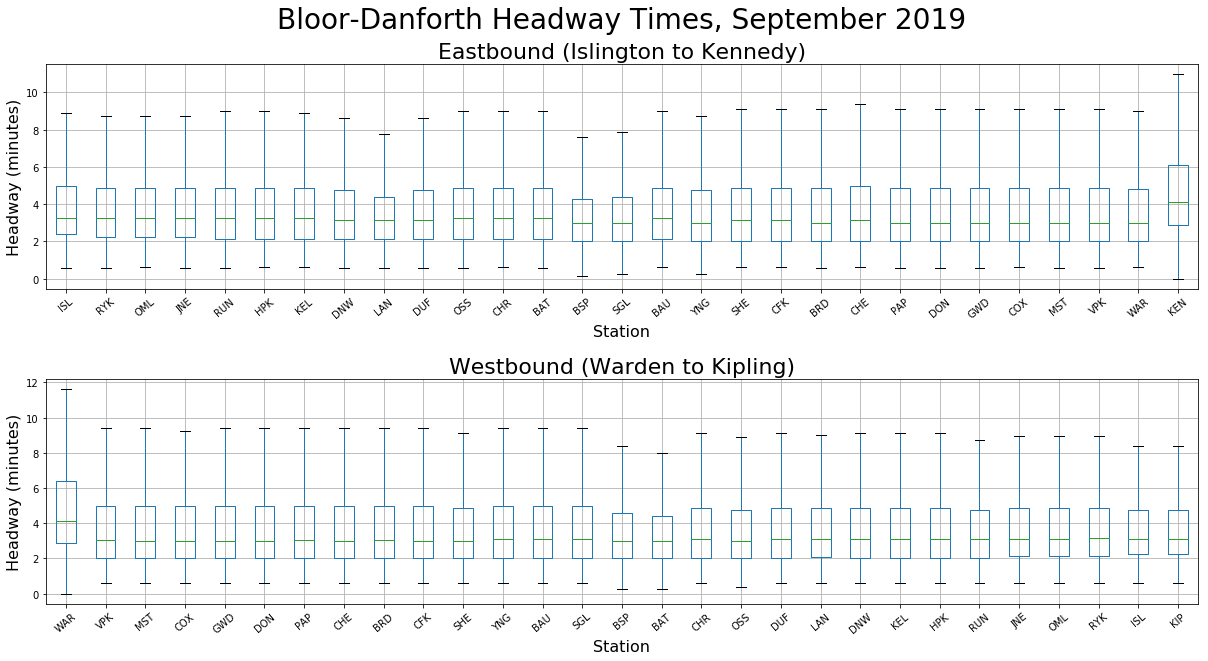

In [18]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(20,10))

ttc_east.boxplot(column = 'headway', by = 'station_char', rot=40, ax = axes[0], showfliers=False)
ttc_west.boxplot(column = 'headway', by = 'station_char', rot=40, ax = axes[1], showfliers=False)

fig.suptitle('Bloor-Danforth Headway Times, September 2019', fontsize=28)
fig.subplots_adjust(hspace = 0.4)

axes[0].set_title('Eastbound (Islington to Kennedy)', fontsize=22)
axes[0].set_xlabel('Station', fontsize=16)
axes[0].set_ylabel("Headway (minutes)",fontsize=16)

axes[1].set_title('Westbound (Warden to Kipling)', fontsize=22)
axes[1].set_xlabel('Station', fontsize=16)
axes[1].set_ylabel("Headway (minutes)",fontsize=16)

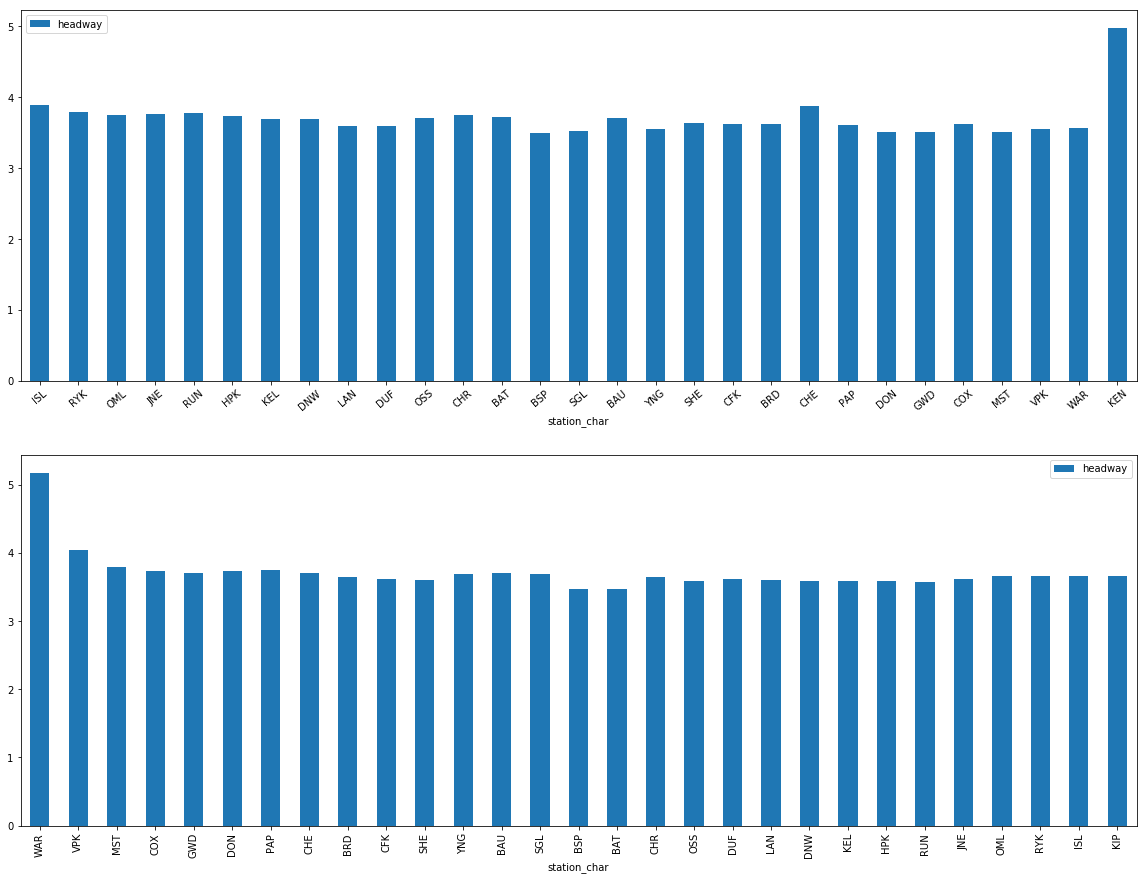

In [19]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize=(20,15))
ttc_east[['station_char','headway']].groupby('station_char').mean().plot(kind='bar', ax = axes[0], rot=40)
ttc_west[['station_char','headway']].groupby('station_char').mean().plot(kind='bar', ax = axes[1])

In [20]:
# eastbound
ttc_east[['station_char','headway']].groupby('station_char').describe()

headway                                                   
               count      mean       std   min   25%   50%   75%    max
station_char                                                           
ISL           5787.0  3.894033  2.347507  0.58  2.37  3.25  4.98  34.72
RYK           5951.0  3.788735  2.075836  0.58  2.25  3.25  4.87  34.00
OML           6026.0  3.745415  2.044563  0.60  2.25  3.25  4.87  35.98
JNE           5999.0  3.761110  2.103059  0.58  2.25  3.25  4.87  36.02
RUN           5974.0  3.773018  2.096634  0.58  2.13  3.25  4.87  35.98
HPK           6027.0  3.739129  2.067288  0.60  2.13  3.25  4.87  36.12
KEL           6112.0  3.692791  2.015261  0.60  2.12  3.23  4.85  36.02
DNW           6120.0  3.686315  2.030461  0.58  2.13  3.13  4.73  35.87
LAN           6275.0  3.588795  1.848224  0.58  2.12  3.12  4.38  34.00
DUF           6271.0  3.599128  1.815310  0.58  2.12  3.13  4.73  31.98
OSS           6081.0  3.707905  1.969327  0.58  2.12  3.25  4.87  35.00
CHR           6018.0  3.746657  2.033976  0.60  2.12  3.25  4.87  33.58
BAT           6064.0  3.720381  2.019188  0.58  2.12  3.25  4.87  32.87
BSP           6446.0  3.494735  1.696692  0.12  2.00  3.00  4.27  33.58
SGL           6401.0  3.519045  1.718622  0.25  2.00  3.00  4.38  32.98
BAU           6086.0  3.706354  1.948890  0.60  2.12  3.23  4.87  32.00
YNG           6357.0  3.544664  1.808071  0.25  2.00  3.00  4.73  31.13
SHE           6203.0  3.633045  2.007982  0.60  2.00  3.12  4.87  32.00
CFK           6239.0  3.618263  1.967618  0.60  2.00  3.12  4.87  32.00
BRD           6229.0  3.620392  2.040039  0.58  2.00  3.00  4.87  40.73
CHE           5840.0  3.874906  2.576731  0.60  2.00  3.12  4.98  36.12
PAP           6260.0  3.600329  2.016573  0.58  2.00  3.00  4.87  36.98
DON           6411.0  3.513386  1.970172  0.58  2.00  3.00  4.87  32.58
GWD           6423.0  3.511351  1.963235  0.58  2.00  3.00  4.85  32.58
COX           6220.0  3.624113  2.026802  0.60  2.00  3.00  4.87  31.00
MST           6436.0  3.506664  2.020300  0.58  2.00  3.00  4.87  35.12
VPK           6358.0  3.550411  2.029915  0.58  2.00  3.00  4.87  33.25
WAR           6317.0  3.569508  2.141866  0.60  2.00  3.00  4.83  32.00
KEN           4523.0  4.978373  3.460113  0.00  2.87  4.12  6.12  49.87

In [21]:
# westbound
ttc_west[['station_char','headway']].groupby('station_char').describe()

headway                                                    
               count      mean       std   min   25%   50%    75%    max
station_char                                                            
WAR           4367.0  5.175826  3.977913  0.00  2.87  4.12  6.380  74.00
VPK           5570.0  4.046219  3.008631  0.58  2.00  3.02  5.000  76.00
MST           5969.0  3.793976  2.604657  0.60  2.00  3.00  5.000  75.00
COX           6070.0  3.730386  2.543906  0.58  2.00  3.00  4.980  76.00
GWD           6081.0  3.708370  2.422182  0.58  2.00  3.00  4.980  41.15
DON           6047.0  3.726463  2.326132  0.58  2.00  3.00  4.980  35.98
PAP           6011.0  3.752993  2.376080  0.58  2.00  3.02  4.980  34.72
CHE           6128.0  3.697330  2.468820  0.58  2.00  3.00  4.980  56.12
BRD           6176.0  3.645210  2.132147  0.58  2.00  3.02  4.955  35.87
CFK           6241.0  3.610604  2.125169  0.58  2.00  3.00  4.980  32.00
SHE           6263.0  3.600142  2.069072  0.58  2.00  3.00  4.880  32.72
YNG           6119.0  3.684171  2.198131  0.60  2.00  3.12  4.980  32.98
BAU           6097.0  3.697637  2.178672  0.60  2.00  3.12  4.980  34.85
SGL           6108.0  3.691496  2.193253  0.58  2.00  3.12  4.980  32.87
BSP           6512.0  3.461467  1.804143  0.25  2.00  3.00  4.600  31.13
BAT           6497.0  3.473960  1.793995  0.25  2.00  3.00  4.400  32.25
CHR           6185.0  3.641643  2.062758  0.58  2.00  3.12  4.870  33.58
OSS           6296.0  3.581977  1.835956  0.38  2.00  3.00  4.750  31.13
DUF           6228.0  3.621959  1.931098  0.58  2.00  3.12  4.870  32.00
LAN           6260.0  3.603107  1.894658  0.60  2.10  3.12  4.870  34.98
DNW           6299.0  3.578692  1.874963  0.58  2.00  3.12  4.850  34.85
KEL           6293.0  3.583979  1.880728  0.60  2.00  3.12  4.850  32.00
HPK           6289.0  3.585007  1.883911  0.60  2.00  3.12  4.870  32.00
RUN           6308.0  3.572784  1.816844  0.58  2.02  3.12  4.750  31.00
JNE           6246.0  3.610195  1.794097  0.60  2.12  3.12  4.865  31.00
OML           6164.0  3.658154  1.778878  0.60  2.12  3.13  4.870  31.00
RYK           6179.0  3.652549  1.750443  0.60  2.13  3.15  4.870  33.72
ISL           6177.0  3.652067  1.754919  0.58  2.25  3.13  4.730  33.25
KIP           6171.0  3.658533  1.775322  0.60  2.25  3.13  4.730  32.00

Next steps:
* Regression to predict headway given time, station, and weather.
* Find more interesting methods of presenting findings.